In [115]:
import os
import torch
import numpy as np
import pandas as pd
import rootutils

rootutils.setup_root(os.getcwd(), indicator=".project-root", pythonpath=True)

PosixPath('/Users/rafnuss/Library/CloudStorage/OneDrive-Vogelwarte/GeoPressureLabel')

In [188]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from src.data.label_datamodule import LabelDataModule
import importlib

importlib.reload(sys.modules["src.data.label_datamodule"])

<module 'src.data.label_datamodule' from '/Users/rafnuss/Library/CloudStorage/OneDrive-Vogelwarte/GeoPressureLabel/src/data/label_datamodule.py'>

In [189]:
dataloader = LabelDataModule()
dataloader.setup()

In [ ]:
data = dataloader.read_data()

In [ ]:
data["tvt"] = None
concept_grp = {
    concept: np.unique(data.loc[data["conceptdoi"] == concept, "tag_id"])
    for concept in data["conceptdoi"].unique()
}
for tag_list in concept_grp.values():
    np.random.shuffle(tag_list)
ratios = np.array(
    [
        dataloader.train_max_samples,
        dataloader.val_max_samples,
        dataloader.test_max_samples,
    ],
)
ratios = ratios / ratios.sum()

for concept, tag_ids in concept_grp.items():
    splits = (ratios.cumsum()[:-1] * len(tag_ids)).astype(int)
    train_ids, val_ids, test_ids = np.split(tag_ids, splits)
    for ids, split in zip([train_ids, val_ids, test_ids], ["train", "val", "test"]):
        data.loc[
            (data["conceptdoi"] == concept) & (data["tag_id"].isin(ids)), "tvt"
        ] = split

In [62]:
data["select"] = False

flight_ratio = 0.5

split_samples = {
    "train": 1000,
    "val": 200,
    "test": 200,
}

for split, n_samples in split_samples.items():
    df_split = data[data["tvt"] == split]
    n_flight = int(flight_ratio * n_samples)
    n_non_flight = n_samples - n_flight

    idx_flight = (
        df_split[df_split["flight"] == True]
        .sample(n=min(n_flight, (df_split["flight"] == True).sum()), random_state=42)
        .index
    )
    idx_non_flight = (
        df_split[df_split["flight"] == False]
        .sample(
            n=min(n_non_flight, (df_split["flight"] == False).sum()), random_state=42
        )
        .index
    )

    data.loc[idx_flight, "select"] = True
    data.loc[idx_non_flight, "select"] = True

,datetime,tag_id,value_act,label_act,conceptdoi,scientific_name,value_pres,label_pres,flight,tvt
0,2015-07-15 00:00:00+00:00,14EZ,0.0,,14439689,Upupa epops,966.0,,False,train
1,2015-07-15 00:00:00+00:00,14DM,0.0,,14439689,Upupa epops,965.0,,False,train
2,2015-07-15 00:05:00+00:00,14DM,0.0,,14439689,Upupa epops,965.0,,False,train
3,2015-07-15 00:05:00+00:00,14EZ,0.0,,14439689,Upupa epops,966.0,,False,train
4,2015-07-15 00:10:00+00:00,14DM,0.0,,14439689,Upupa epops,965.0,,False,train
...,...,...,...,...,...,...,...,...,...,...
3142580,2020-09-28 17:50:00+00:00,24FD,0.0,,16730669,Caprimulgus europeaus,813.0,discard,False,train
3142581,2020-09-28 17:55:00+00:00,24FD,0.0,,16730669,Caprimulgus europeaus,813.0,discard,False,train
3142582,2020-09-28 18:00:00+00:00,24FD,0.0,,16730669,Caprimulgus europeaus,811.0,discard,False,train
3142583,2020-09-28 18:05:00+00:00,24FD,0.0,,16730669,Caprimulgus europeaus,811.0,discard,False,train


In [190]:
def plot_tagid_timeseries(tag_id, df):
    df_tag = df[df["tag_id"] == tag_id].copy()
    if df_tag.empty:
        print(f"No data for tag_id {tag_id}")
        return
    # Sort by datetime
    df_tag = df_tag.sort_values("datetime")
    # Prepare figure
    fig, ax1 = plt.subplots(figsize=(12, 5))
    color1 = "tab:blue"
    color2 = "tab:orange"
    ax1.set_xlabel("Datetime")
    ax1.set_ylabel("activity", color=color1)
    ln1 = ax1.plot(
        df_tag["datetime"], df_tag["value_act"], color=color1, label="activity"
    )
    ax1.tick_params(axis="y", labelcolor=color1)
    ax2 = ax1.twinx()
    ax2.set_ylabel("pressure (hPa)", color=color2)
    ln2 = ax2.plot(
        df_tag["datetime"], df_tag["value_pres"], color=color2, label="pressure (hPa)"
    )
    ax2.tick_params(axis="y", labelcolor=color2)
    # Plot label_act points if not empty and not ""
    if "label_act" in df_tag.columns and df_tag["label_act"].notna().any():
        for label in df_tag["label_act"].dropna().unique():
            if label == "":
                continue
            mask = df_tag["label_act"] == label
            ax1.scatter(
                df_tag.loc[mask, "datetime"],
                df_tag.loc[mask, "value_act"],
                label=f"label_act: {label}",
                s=40,
            )
    # Plot label_pres points if not empty and not ""
    if "label_pres" in df_tag.columns and df_tag["label_pres"].notna().any():
        for label in df_tag["label_pres"].dropna().unique():
            if label == "":
                continue
            mask = df_tag["label_pres"] == label
            ax2.scatter(
                df_tag.loc[mask, "datetime"],
                df_tag.loc[mask, "value_pres"],
                label=f"label_pres: {label}",
                s=40,
            )
    # Title with scientific_name
    sci_name = (
        df_tag["scientific_name"].iloc[0] if "scientific_name" in df_tag.columns else ""
    )
    plt.title(f"{tag_id} | {sci_name}")
    fig.autofmt_xdate()
    fig.tight_layout()
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.show()

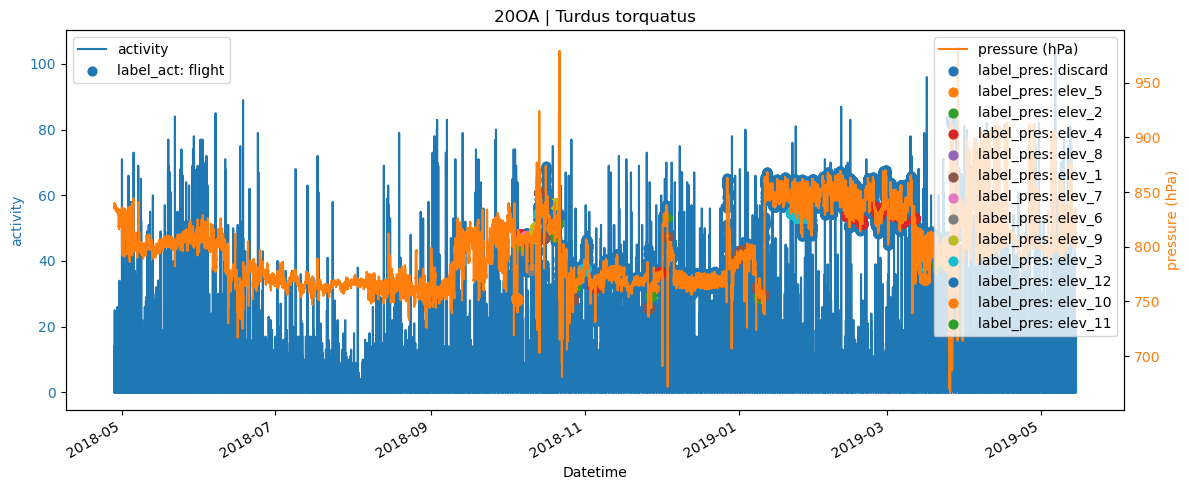

In [191]:
plot_tagid_timeseries(
    "20OA", dataloader.data
)  # replace with a valid tag_id from your data

526
155
229
789
324


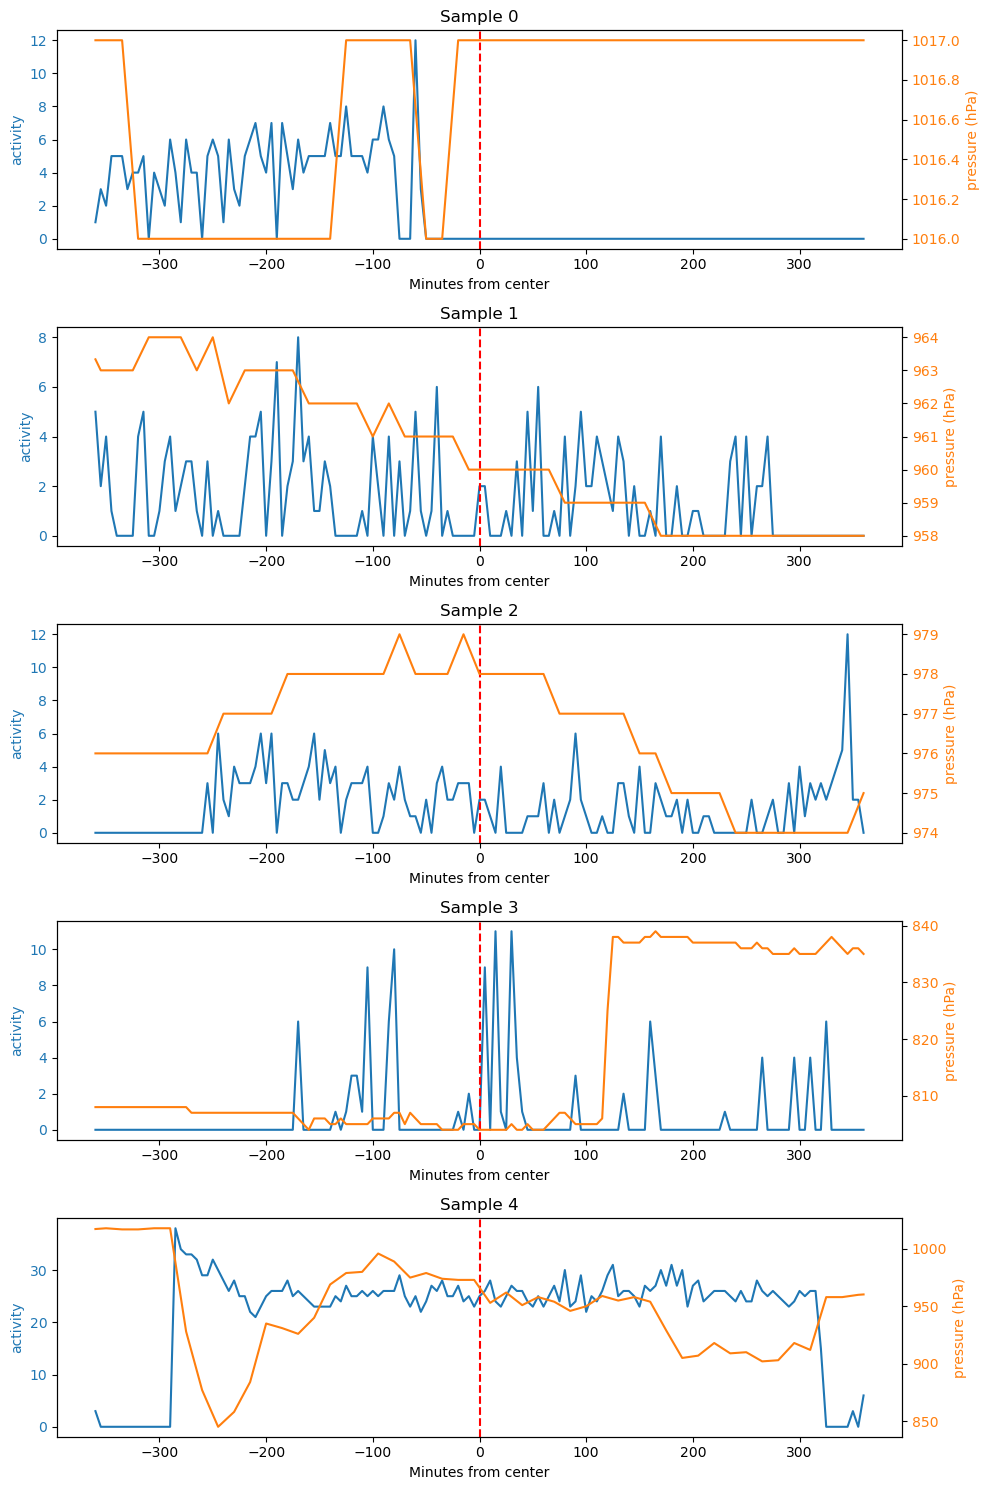

In [197]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import numpy as np

train_dataloader = dataloader.train_dataloader()

n_samples = 5
train_dataset = train_dataloader.dataset
total_samples = len(train_dataset)
random_indices = np.random.choice(total_samples, n_samples, replace=False)


fig, axes = plt.subplots(n_samples, 1, figsize=(10, 3 * n_samples), sharex=False)
if n_samples == 1:
    axes = [axes]
for i, idx in enumerate(random_indices):
    print(idx)
    X, y = train_dataset[idx]

    # Take the first sample in the batch (if batch size > 1)
    X_np = X.numpy() if hasattr(X, "numpy") else X
    # You may want to get the corresponding row info from the dataset if needed
    # Here, we just plot the windowed sequence
    window = X_np.shape[0] // 2
    # x-axis: relative time centered at 0, 5min intervals
    x_datetimes = [5 * (j - window) for j in range(X_np.shape[0])]
    ax1 = axes[i]
    color1 = "tab:blue"
    color2 = "tab:orange"
    ax1.set_ylabel("activity", color=color1)
    ln1 = ax1.plot(x_datetimes, X_np[:, 0], color=color1)
    ax1.tick_params(axis="y", labelcolor=color1)
    ax2 = ax1.twinx()
    ax2.set_ylabel("pressure (hPa)", color=color2)
    ln2 = ax2.plot(x_datetimes, X_np[:, 1], color=color2)
    ax2.tick_params(axis="y", labelcolor=color2)
    # Add a red vertical line at the center (0)
    ax1.axvline(0, color="red", linestyle="--")
    ax1.set_xlabel("Minutes from center")
    ax1.set_title(f"Sample {i}")
fig.tight_layout()
plt.show()